# Count of first class tickets for the next month.


# Import libraries


In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV

import xgboost as xg
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Load data

In [2]:
server = 'mohamedibrahim'
database = 'railway_dwh'

connection_string = (
    f'mssql+pyodbc://mohamedibrahim/railway_dwh'
    '?driver=ODBC+Driver+17+for+SQL+Server'
    '&Trusted_Connection=yes'
)
engine = create_engine(connection_string)

query = """
SELECT date_of_purchase,
COUNT(CASE WHEN ticket_class = 'First Class' THEN 1 END) AS First_Class_Count
FROM silver.railway
where month(date_of_purchase) != '12'
GROUP BY date_of_purchase
ORDER BY date_of_purchase
"""
df = pd.read_sql(query, engine)

# Preprocessing & Feature engineering

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date_of_purchase   121 non-null    object
 1   First_Class_Count  121 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.0+ KB


In [4]:
df['date_of_purchase'] = pd.to_datetime(df['date_of_purchase'])

In [5]:
df.head()

,date_of_purchase,First_Class_Count
0,2024-01-01,11
1,2024-01-02,24
2,2024-01-03,33
3,2024-01-04,21
4,2024-01-05,19


In [6]:
df.set_index('date_of_purchase', inplace=True)

In [7]:
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['day'] = df.index.day

In [8]:
import holidays


uk_holidays = holidays.UnitedKingdom(subdiv='ENG', years=2024, observed=True)
df['is_holiday'] = df.index.map(lambda x: x in uk_holidays)


In [9]:
df['is_holiday'] = df['is_holiday'].astype(int)


In [10]:
df['lag 1'] = df['First_Class_Count'].shift(1).fillna(0)
df['lag 7'] = df['First_Class_Count'].shift(7).fillna(0)
df['lag 14'] = df['First_Class_Count'].shift(14).fillna(0)


In [11]:
df['lag 1'] = df['lag 1'].astype(int)
df['lag 7'] = df['lag 7'].astype(int)
df['lag 14'] = df['lag 14'].astype(int)

# Forecasting

## Prepare Train & Test data

In [12]:
train = df.loc[df.index < '2024-04-11']
test = df.loc[df.index >= '2024-04-11']

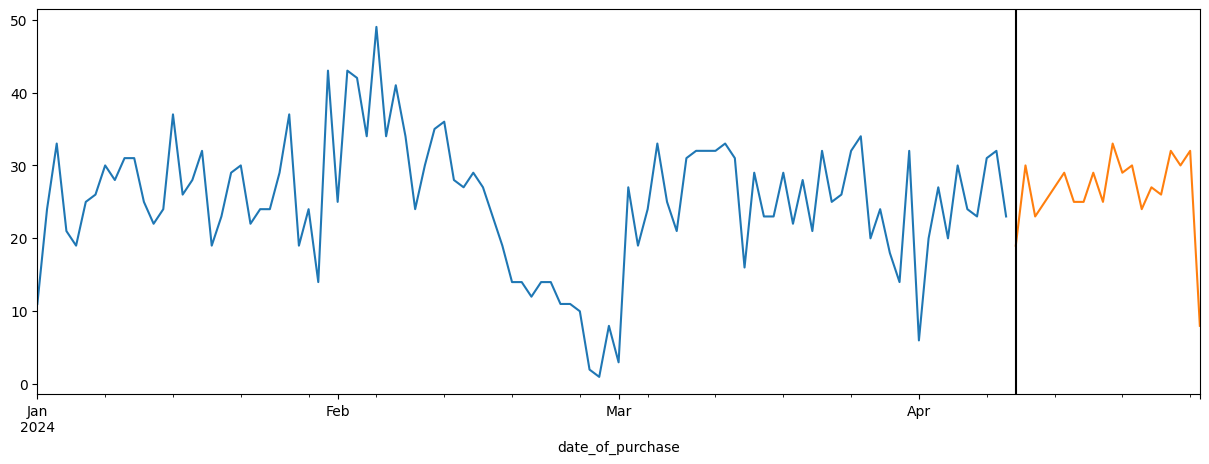

In [13]:
fig, ax = plt.subplots(figsize=(15,5))
train['First_Class_Count'].plot(ax=ax,label='tarining set')
test['First_Class_Count'].plot(ax=ax,label='test set')
ax.axvline('2024-04-11', color='black')
plt.show()


## Creat model

In [14]:
# define the features
features = [
    'month', 'day', 'day_of_week', 'is_holiday', 'lag 1', 'lag 7', 'lag 14'
    ]

In [15]:
# prepare the training data
x_train = train[features]
y_train = train['First_Class_Count']

x_test = test[features]
y_test = test['First_Class_Count']

In [137]:
# train XGBOOST model
model = xg.XGBRegressor(
    n_estimators = 200,          
    learning_rate = 0.03,          
    max_depth = 3,                 
    random_state = 42,             
)


model.fit(
    x_train, 
    y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    verbose=True
)


[0]	validation_0-rmse:8.80835	validation_1-rmse:5.59226
[1]	validation_0-rmse:8.69855	validation_1-rmse:5.60627
[2]	validation_0-rmse:8.57489	validation_1-rmse:5.57877
[3]	validation_0-rmse:8.47190	validation_1-rmse:5.59367
[4]	validation_0-rmse:8.35575	validation_1-rmse:5.56897
[5]	validation_0-rmse:8.24267	validation_1-rmse:5.56836
[6]	validation_0-rmse:8.13457	validation_1-rmse:5.54643
[7]	validation_0-rmse:8.04274	validation_1-rmse:5.55913
[8]	validation_0-rmse:7.94034	validation_1-rmse:5.55903
[9]	validation_0-rmse:7.84193	validation_1-rmse:5.53955
[10]	validation_0-rmse:7.75832	validation_1-rmse:5.55154
[11]	validation_0-rmse:7.66583	validation_1-rmse:5.53402
[12]	validation_0-rmse:7.57607	validation_1-rmse:5.53458
[13]	validation_0-rmse:7.50001	validation_1-rmse:5.54586
[14]	validation_0-rmse:7.41586	validation_1-rmse:5.53033
[15]	validation_0-rmse:7.33473	validation_1-rmse:5.53118
[16]	validation_0-rmse:7.26551	validation_1-rmse:5.54175
[17]	validation_0-rmse:7.18890	validation

[28]	validation_0-rmse:6.51012	validation_1-rmse:5.48735
[29]	validation_0-rmse:6.45754	validation_1-rmse:5.48969
[30]	validation_0-rmse:6.40643	validation_1-rmse:5.48187
[31]	validation_0-rmse:6.35853	validation_1-rmse:5.48039
[32]	validation_0-rmse:6.31054	validation_1-rmse:5.47814
[33]	validation_0-rmse:6.26368	validation_1-rmse:5.47079
[34]	validation_0-rmse:6.21936	validation_1-rmse:5.47958
[35]	validation_0-rmse:6.17574	validation_1-rmse:5.48202
[36]	validation_0-rmse:6.13437	validation_1-rmse:5.49047
[37]	validation_0-rmse:6.09229	validation_1-rmse:5.48368
[38]	validation_0-rmse:6.05340	validation_1-rmse:5.49174
[39]	validation_0-rmse:6.01455	validation_1-rmse:5.48880
[40]	validation_0-rmse:5.97801	validation_1-rmse:5.49658
[41]	validation_0-rmse:5.93892	validation_1-rmse:5.48906
[42]	validation_0-rmse:5.90842	validation_1-rmse:5.49315
[43]	validation_0-rmse:5.87146	validation_1-rmse:5.49015
[44]	validation_0-rmse:5.83589	validation_1-rmse:5.48410
[45]	validation_0-rmse:5.80810	

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

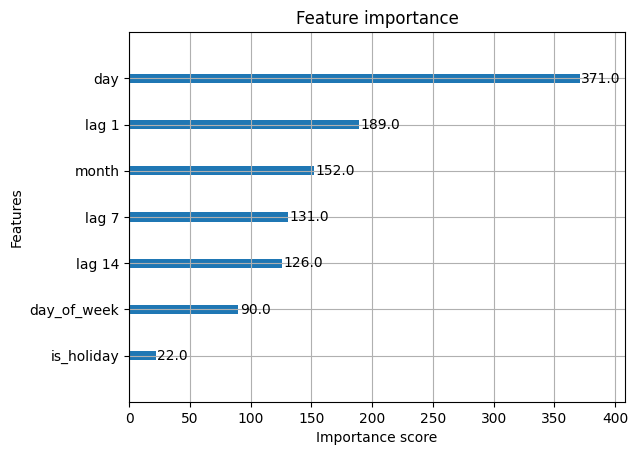

In [138]:
xg.plot_importance(model)
plt.show()


In [139]:
# Make predictions
train_preds = model.predict(x_train)
test_preds = model.predict(x_test)


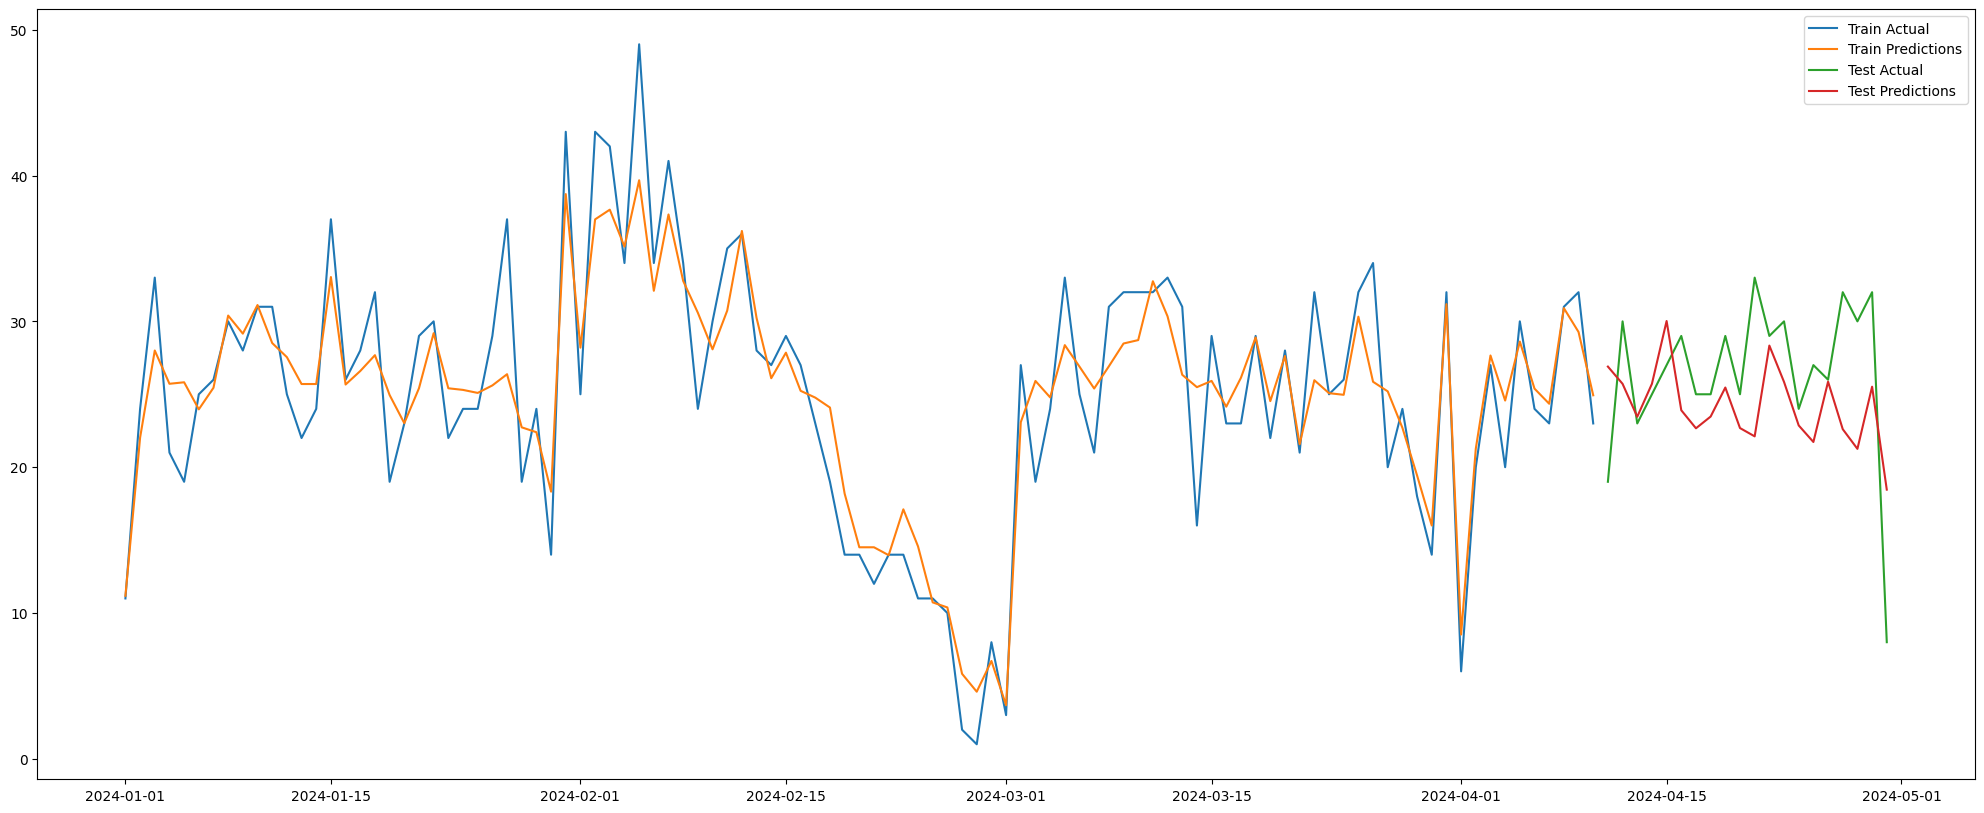

In [140]:
# Plot results
plt.figure(figsize=(25,10))
plt.plot(train.index, y_train.rolling(window=1).mean(), label='Train Actual')
plt.plot(train.index, pd.Series(train_preds).rolling(window=1).mean(), label='Train Predictions')
plt.plot(test.index, y_test.rolling(window=1).mean(), label='Test Actual')
plt.plot(test.index, pd.Series(test_preds).rolling(window=1).mean(), label='Test Predictions')
plt.legend()
plt.show()


## Forecasting the Next Month 


In [141]:
# Create a dataframe for the next 30 days
last_date = df.index.max()
next_month_dates = pd.date_range(start=last_date + timedelta(days=1), periods=30)
future_df = pd.DataFrame(index=next_month_dates)


In [142]:

future_df['day_of_week'] = future_df.index.dayofweek
future_df['month'] = future_df.index.month
future_df['day'] = future_df.index.day
future_df['is_holiday'] = future_df.index.map(lambda x: x in uk_holidays).astype(int)


In [143]:

# Copy original dataframe to append predictions for lag calculation
history = df.copy()

# Placeholder for predictions
predictions = []


In [144]:

# Forecast each day one by one 
for date in future_df.index:
    row = {}
    row['month'] = date.month
    row['day'] = date.day
    row['day_of_week'] = date.dayofweek
    row['is_holiday'] = int(date in uk_holidays)
    row['lag 1'] = history['First_Class_Count'].iloc[-1]
    row['lag 7'] = history['First_Class_Count'].iloc[-7] if len(history) >= 7 else 0
    row['lag 14'] = history['First_Class_Count'].iloc[-14] if len(history) >= 14 else 0

    # Predict
    features_row = pd.DataFrame([row])
    pred = model.predict(features_row)[0]

    # Store prediction
    predictions.append(pred)

    # Append to history to update lags for next iteration
    history = pd.concat([
        history,
        pd.DataFrame({'First_Class_Count': [pred]}, index=[date])
    ])


In [145]:

# Assign predictions to future_df
future_df['predicted_First_Class_Count'] = predictions


# Results

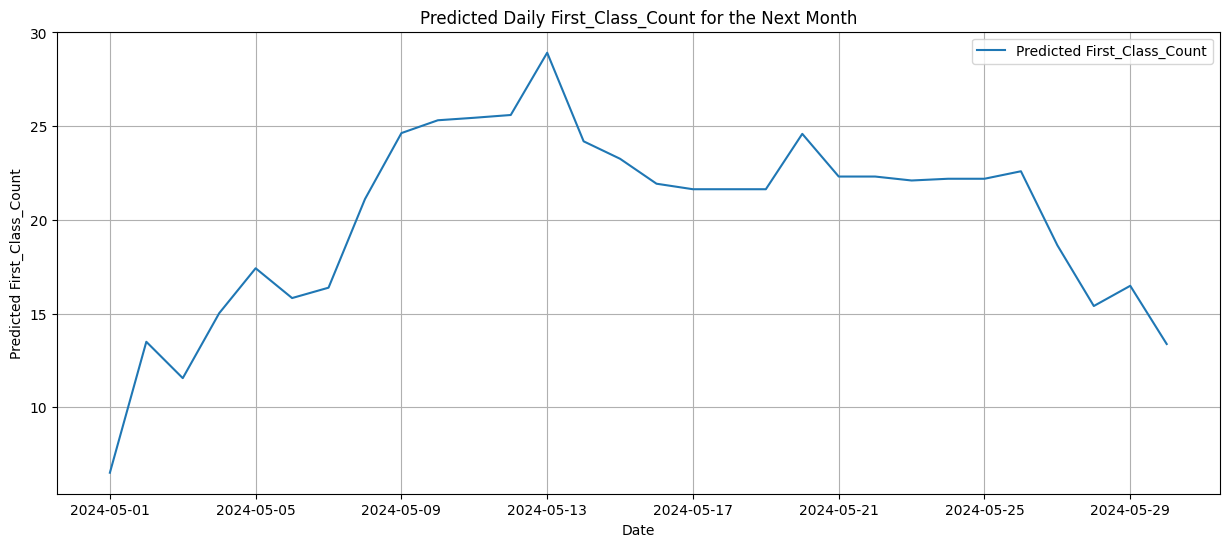


Predicted Daily First_Class_Count for the Next Month:
2024-05-01     6.514107
2024-05-02    13.498974
2024-05-03    11.558907
2024-05-04    15.024490
2024-05-05    17.420008
2024-05-06    15.831361
2024-05-07    16.384394
2024-05-08    21.110304
2024-05-09    24.631456
2024-05-10    25.314980
2024-05-11    25.448284
2024-05-12    25.595940
2024-05-13    28.917879
2024-05-14    24.191961
2024-05-15    23.260176
2024-05-16    21.930574
2024-05-17    21.636065
2024-05-18    21.636065
2024-05-19    21.636065
2024-05-20    24.590244
2024-05-21    22.313021
2024-05-22    22.313021
2024-05-23    22.102472
2024-05-24    22.194942
2024-05-25    22.194942
2024-05-26    22.594526
2024-05-27    18.645721
2024-05-28    15.406573
2024-05-29    16.485373
2024-05-30    13.379150
Freq: D, Name: predicted_First_Class_Count, dtype: float32


,day_of_week,month,day,is_holiday,predicted_First_Class_Count
2024-05-01,2,5,1,0,6.514107
2024-05-02,3,5,2,0,13.498974
2024-05-03,4,5,3,0,11.558907
2024-05-04,5,5,4,0,15.024490
2024-05-05,6,5,5,0,17.420008
2024-05-06,0,5,6,1,15.831361
2024-05-07,1,5,7,0,16.384394
2024-05-08,2,5,8,0,21.110304
2024-05-09,3,5,9,0,24.631456
2024-05-10,4,5,10,0,25.314980


In [146]:

# Plot forecasted First_Class_Count
plt.figure(figsize=(15, 6))
plt.plot(future_df.index, future_df['predicted_First_Class_Count'], label='Predicted First_Class_Count')
plt.title('Predicted Daily First_Class_Count for the Next Month')
plt.xlabel('Date')
plt.ylabel('Predicted First_Class_Count')
plt.legend()
plt.grid(True)
plt.show()

# Print forecasted values
print("\nPredicted Daily First_Class_Count for the Next Month:")
print(future_df['predicted_First_Class_Count'])
future_df
